In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

In [22]:
data_path = "../data/raw/customers_raw.csv"
df = pd.read_csv(data_path)

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [15]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

In [25]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols.remove('loan_status')
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

In [27]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((26064, 11), (6517, 11))

In [28]:
from sklearn.impute import SimpleImputer

# Numeric preprocessing: impute missing values, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to apply the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        max_iter=500,
        class_weight='balanced',   # helps with your 78/22 imbalance
        solver='lbfgs'
    ))
])

log_reg_clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Logistic Regression – classification report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5095
           1       0.55      0.78      0.65      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.80      0.76      6517
weighted avg       0.85      0.81      0.82      6517

Logistic Regression – ROC AUC:
0.8711793780339513


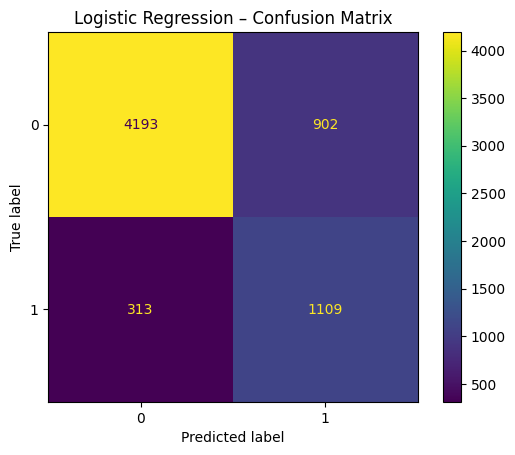

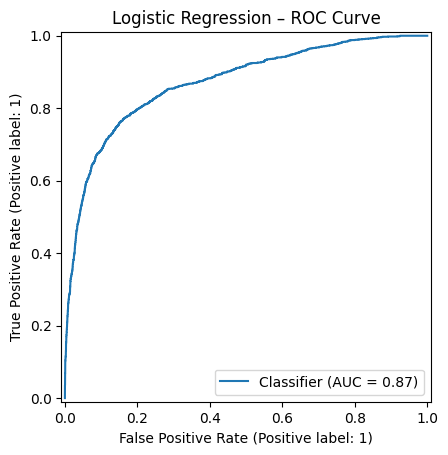

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

# Text metrics
print("Logistic Regression – classification report")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression – ROC AUC:")
print(roc_auc_score(y_test, y_proba_lr))

# Confusion matrix plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

# ROC curve plot
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression – ROC Curve")
plt.show()

In [37]:
# Training a Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])
rf_clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Random Forest – classification report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.72      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.94      0.93      0.93      6517

Random Forest – ROC AUC:
0.9316381853089472


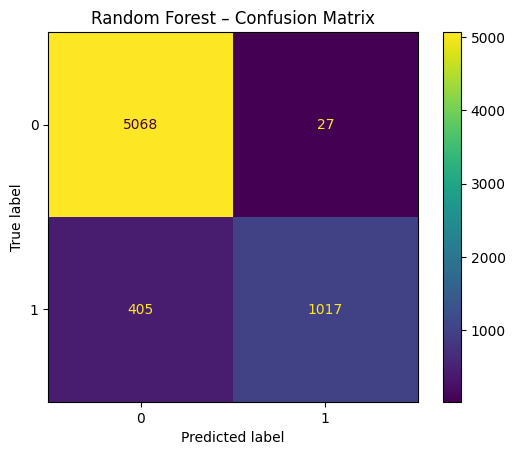

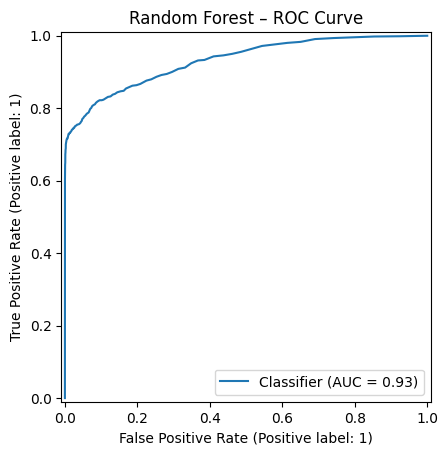

In [38]:
# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest – classification report")
print(classification_report(y_test, y_pred_rf))

print("Random Forest – ROC AUC:")
print(roc_auc_score(y_test, y_proba_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Random Forest – Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest – ROC Curve")
plt.show()

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(
        random_state=42
    ))
])

gb_clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Gradient Boosting – classification report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5095
           1       0.95      0.70      0.81      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.88      6517
weighted avg       0.93      0.93      0.92      6517

Gradient Boosting – ROC AUC:
0.9262260372196895


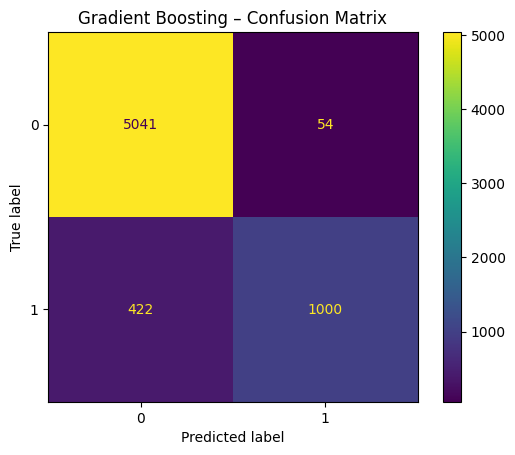

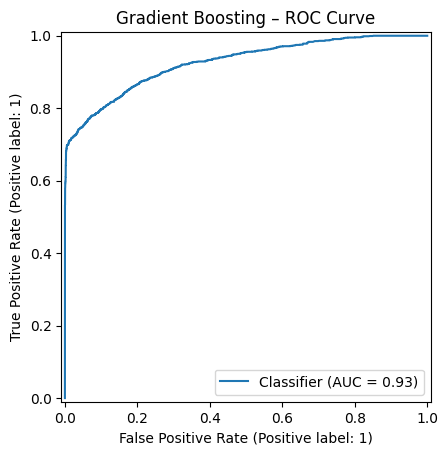

In [41]:
y_pred_gb = gb_clf.predict(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

print("Gradient Boosting – classification report")
print(classification_report(y_test, y_pred_gb))

print("Gradient Boosting – ROC AUC:")
print(roc_auc_score(y_test, y_proba_gb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)
plt.title("Gradient Boosting – Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_gb)
plt.title("Gradient Boosting – ROC Curve")
plt.show()

Saved thr preproccessor and the model!


In [46]:
# Final pipeline: preprocessor + RF model together
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_clf.named_steps['model'])
])

# Save final pipeline
joblib.dump(final_model, "../models/final_risk_model.pkl")

print("Final production-ready model saved!")

Final production-ready model saved!
